In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.ensemble import IsolationForest




sns.set(style="whitegrid")

##### Charger les données

In [2]:
import pandas as pd

df_compteurs = pd.read_csv("/home/marwa/prevision-du-Trafic-Cyclable/notebooks/data/MMM_MMM_GeolocCompteurs .csv")
df_compteurs.head()


,Nom du com,N° Série,N° Sér_1,Latitude,Longitude,OSM_Line_i
0,Compteur Vélo Tanneurs,XTH19101158,XTH19101158,43.616209,3.874408,188609530
1,Compteur Piéton/Vélo Berracasa,X2H19070220,X2H19070220,43.609699,3.896940,121403593
2,Compteur Vélo Lodève Celleneuve,Y2H20042633,X2H20042633,43.614650,3.833600,734202564
3,Compteur Vélo Lavérune,X2H20042632,X2H20042632,43.590700,3.813240,97705885
4,Compteur Vélo Vieille poste,ZLT25011699,ZLT25011699,43.615742,3.909632,676645909


###### Vérifier les valeurs manquantes

In [3]:
# Vérifier les valeurs manquantes
df_compteurs.isna().sum()

Nom du com     0
N° Série       0
N° Sér_1      28
Latitude       0
Longitude      0
OSM_Line_i     0
dtype: int64

###### Nombre de compteurs :

In [4]:
print("Nombre de compteurs :", df_compteurs.shape[0])


Nombre de compteurs : 53


##### Distribution par latitude/longitude

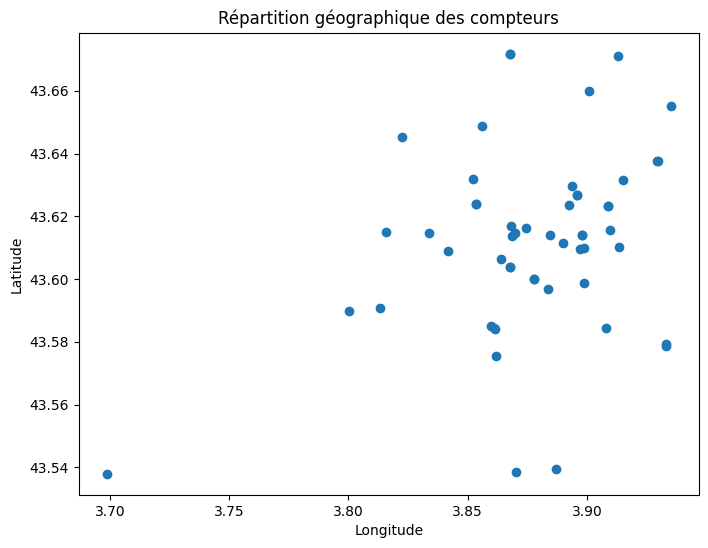

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_compteurs['Longitude'], df_compteurs['Latitude'])
plt.title("Répartition géographique des compteurs")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


###### Compteurs avec doublons ou mêmes coordonnées :

In [10]:
df_compteurs[df_compteurs.duplicated(subset=['Latitude','Longitude'], keep=False)]


,Nom du com,N° Série,N° Sér_1,Latitude,Longitude,OSM_Line_i
5,Compteur Vélo Delmas 2,Y2H20063164,X2H20063164,43.626698,3.895629,105575465
6,Compteur Vélo Delmas 1,Y2H20063163,X2H20063163,43.626698,3.895629,105575465
11,Compteur Vélo Père Soulas 1,X2H21070341,NaN,43.623870,3.853390,135001721
12,Compteur Vélo Père Soulas 2,X2H21070342,NaN,43.623870,3.853390,135001721
13,Compteur Vélo M17 Montferrier 1,X2H21070343,NaN,43.671790,3.867914,755700690
14,Compteur Vélo N17 Montferrier 2,X2H21070347,NaN,43.671790,3.867914,755700690
35,Compteur Vélo Vieussens1,X2H22104775,NaN,43.600100,3.877600,8584788
36,Compteur Vélo Vieussens2,X2H22104776,NaN,43.600100,3.877600,8584788
37,Compteur Vélo Pompignane1,X2H22104773,NaN,43.614000,3.898100,376991821
38,Compteur Vélo Pompignane2,X2H22104774,NaN,43.614000,3.898100,31450626


In [13]:
import folium

m = folium.Map(location=[43.61, 3.87], zoom_start=12)

for _, row in df_compteurs.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=4,
        tooltip=row['Nom du com']
    ).add_to(m)

m


In [60]:
import requests
import pandas as pd

# URL de l'API
url = "https://portail-api-data.montpellier3m.fr/ecocounter?limit=1000"

# Requête GET
response = requests.get(url)

# Vérifier que la requête a fonctionné
if response.status_code == 200:
    data = response.json()  # récupère le JSON
else:
    print("Erreur :", response.status_code)
    data = []

# Convertir en DataFrame si des données existent
if data:
    df_counts = pd.DataFrame(data)
    print(df_counts.head())
else:
    print("Pas de données")


                                   id        type  \
0  urn:ngsi-ld:EcoCounter:XTH19101158  EcoCounter   
1  urn:ngsi-ld:EcoCounter:X2H22104775  EcoCounter   
2  urn:ngsi-ld:EcoCounter:X2H20042632  EcoCounter   
3  urn:ngsi-ld:EcoCounter:X2H20063164  EcoCounter   
4  urn:ngsi-ld:EcoCounter:X2H19070220  EcoCounter   

                                          deviceType  \
0  {'type': 'Text', 'value': 'TrafficFlowObserved...   
1  {'type': 'Text', 'value': 'TrafficFlowObserved...   
2  {'type': 'Text', 'value': 'TrafficFlowObserved...   
3  {'type': 'Text', 'value': 'TrafficFlowObserved...   
4  {'type': 'Text', 'value': 'TrafficFlowObserved...   

                                           intensity  \
0  {'type': 'Number', 'value': 2, 'metadata': {'T...   
1  {'type': 'Number', 'value': 0, 'metadata': {'T...   
2  {'type': 'Number', 'value': 0, 'metadata': {'T...   
3  {'type': 'Number', 'value': 0, 'metadata': {'T...   
4  {'type': 'Number', 'value': 10, 'metadata': {'...   

       

In [63]:
# Extraire le count réel
df_counts['count'] = df_counts['intensity'].apply(lambda x: x.get('value') if isinstance(x, dict) else x)

# Extraire le type de véhicule
df_counts['vehicle'] = df_counts['vehicleType'].apply(lambda x: x.get('value') if isinstance(x, dict) else x)

# Extraire la lane
df_counts['lane'] = df_counts['laneId'].apply(lambda x: x.get('value') if isinstance(x, dict) else x)

# Si tu veux, convertir location en tuple lat/lon
df_counts['lat'] = df_counts['location'].apply(lambda x: x.get('latitude') if isinstance(x, dict) else None)
df_counts['lon'] = df_counts['location'].apply(lambda x: x.get('longitude') if isinstance(x, dict) else None)

df_counts.head()


,id,type,deviceType,intensity,laneId,location,reversedLane,vehicleType,compteur,count,vehicle,lane,lat,lon
0,urn:ngsi-ld:EcoCounter:XTH19101158,EcoCounter,"{'type': 'Text', 'value': 'TrafficFlowObserved...","{'type': 'Number', 'value': 2, 'metadata': {'T...","{'type': 'Number', 'value': 188609530, 'metada...","{'type': 'geo:json', 'value': {'type': 'Point'...","{'type': 'Boolean', 'value': False, 'metadata'...","{'type': 'Text', 'value': 'bicycle', 'metadata...",XTH19101158,2,bicycle,188609530.0,None,None
1,urn:ngsi-ld:EcoCounter:X2H22104775,EcoCounter,"{'type': 'Text', 'value': 'TrafficFlowObserved...","{'type': 'Number', 'value': 0, 'metadata': {'T...","{'type': 'Number', 'value': 8584788, 'metadata...","{'type': 'geo:json', 'value': {'type': 'Point'...","{'type': 'Boolean', 'value': False, 'metadata'...","{'type': 'Text', 'value': 'bicycle', 'metadata...",X2H22104775,0,bicycle,8584788.0,None,None
2,urn:ngsi-ld:EcoCounter:X2H20042632,EcoCounter,"{'type': 'Text', 'value': 'TrafficFlowObserved...","{'type': 'Number', 'value': 0, 'metadata': {'T...","{'type': 'Number', 'value': 97705885, 'metadat...","{'type': 'geo:json', 'value': {'type': 'Point'...","{'type': 'Boolean', 'value': False, 'metadata'...","{'type': 'Text', 'value': 'bicycle', 'metadata...",X2H20042632,0,bicycle,97705885.0,None,None
3,urn:ngsi-ld:EcoCounter:X2H20063164,EcoCounter,"{'type': 'Text', 'value': 'TrafficFlowObserved...","{'type': 'Number', 'value': 0, 'metadata': {'T...","{'type': 'Number', 'value': 105575465, 'metada...","{'type': 'geo:json', 'value': {'type': 'Point'...","{'type': 'Boolean', 'value': False, 'metadata'...","{'type': 'Text', 'value': 'bicycle', 'metadata...",X2H20063164,0,bicycle,105575465.0,None,None
4,urn:ngsi-ld:EcoCounter:X2H19070220,EcoCounter,"{'type': 'Text', 'value': 'TrafficFlowObserved...","{'type': 'Number', 'value': 10, 'metadata': {'...","{'type': 'Number', 'value': 121403593, 'metada...","{'type': 'geo:json', 'value': {'type': 'Point'...","{'type': 'Boolean', 'value': False, 'metadata'...","{'type': 'Text', 'value': 'bicycle', 'metadata...",X2H19070220,10,bicycle,121403593.0,None,None


In [65]:
import pandas as pd
import ast

# Charger le CSV
df_counts = pd.read_csv("data/comptages_reel.csv")

# Extraire count
df_counts['count'] = df_counts['intensity'].apply(lambda x: ast.literal_eval(x).get('value') if pd.notna(x) else None)

# Extraire la date
def extract_date(x):
    try:
        d = ast.literal_eval(x)  # Convertit la string en dict
        return d.get('metadata', {}).get('TimeInstant', {}).get('value')
    except:
        return None

df_counts['date'] = df_counts['intensity'].apply(extract_date)
df_counts['date'] = pd.to_datetime(df_counts['date'], errors='coerce')

# Vérifier le résultat
df_counts[['compteur', 'date', 'count']].head()


,compteur,date,count
0,XTH19101158,2025-11-27 04:00:00+00:00,2
1,X2H22104775,2025-11-27 03:00:00+00:00,0
2,X2H20042632,2024-02-01 02:00:00+00:00,0
3,X2H20063164,1899-11-30 08:00:00+00:00,0
4,X2H19070220,2025-11-26 23:00:00+00:00,10


###### Analyse des tendances horaires et quotidiennes

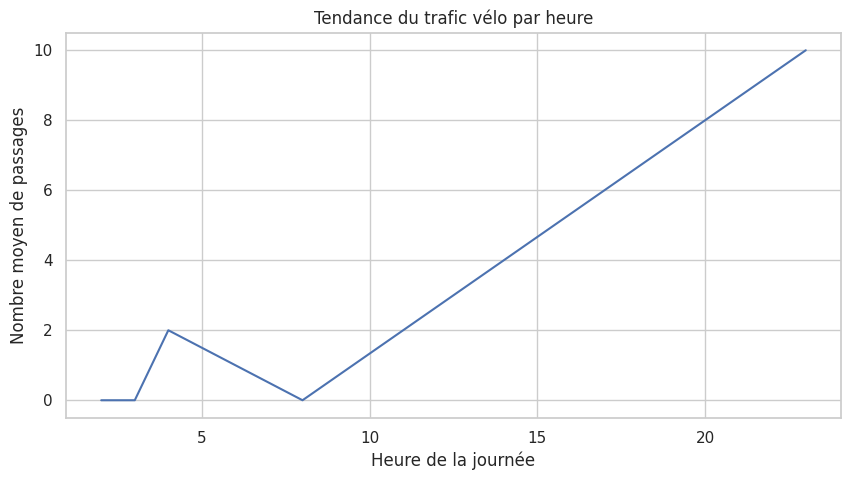

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajouter des colonnes pour faciliter l'analyse
df_counts['hour'] = df_counts['date'].dt.hour
df_counts['day_of_week'] = df_counts['date'].dt.day_name()

# Moyenne de passages par heure (toutes stations confondues)
hourly_trend = df_counts.groupby('hour')['count'].mean()

plt.figure(figsize=(10,5))
sns.lineplot(x=hourly_trend.index, y=hourly_trend.values)
plt.title("Tendance du trafic vélo par heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre moyen de passages")
plt.show()


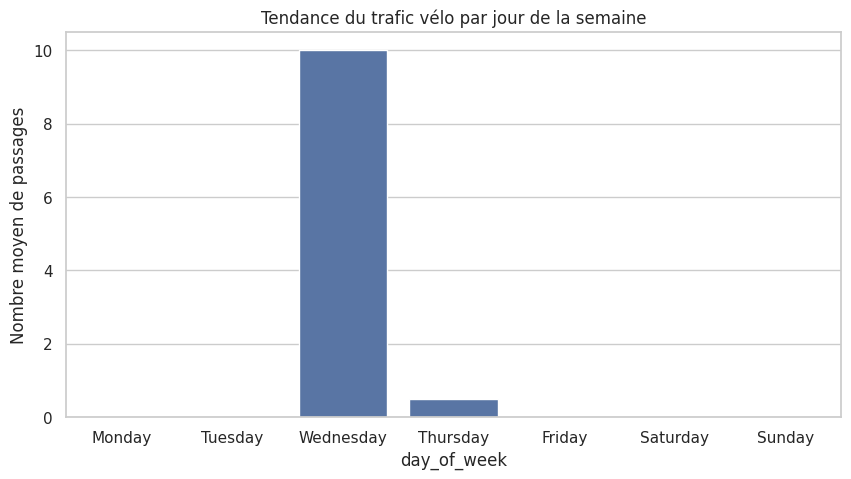

In [67]:
weekly_trend = df_counts.groupby('day_of_week')['count'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

plt.figure(figsize=(10,5))
sns.barplot(x=weekly_trend.index, y=weekly_trend.values)
plt.title("Tendance du trafic vélo par jour de la semaine")
plt.ylabel("Nombre moyen de passages")
plt.show()


###### Détection d’anomalies simples

In [68]:
df_counts[df_counts['count'].isna() | (df_counts['count']==0)]


,id,type,deviceType,intensity,laneId,location,reversedLane,vehicleType,compteur,count,vehicle,lane,lat,lon,date,hour,day_of_week
1,urn:ngsi-ld:EcoCounter:X2H22104775,EcoCounter,"{'type': 'Text', 'value': 'TrafficFlowObserved...","{'type': 'Number', 'value': 0, 'metadata': {'T...","{'type': 'Number', 'value': 8584788, 'metadata...","{'type': 'geo:json', 'value': {'type': 'Point'...","{'type': 'Boolean', 'value': False, 'metadata'...","{'type': 'Text', 'value': 'bicycle', 'metadata...",X2H22104775,0,bicycle,8584788.0,NaN,NaN,2025-11-27 03:00:00+00:00,3,Thursday
2,urn:ngsi-ld:EcoCounter:X2H20042632,EcoCounter,"{'type': 'Text', 'value': 'TrafficFlowObserved...","{'type': 'Number', 'value': 0, 'metadata': {'T...","{'type': 'Number', 'value': 97705885, 'metadat...","{'type': 'geo:json', 'value': {'type': 'Point'...","{'type': 'Boolean', 'value': False, 'metadata'...","{'type': 'Text', 'value': 'bicycle', 'metadata...",X2H20042632,0,bicycle,97705885.0,NaN,NaN,2024-02-01 02:00:00+00:00,2,Thursday
3,urn:ngsi-ld:EcoCounter:X2H20063164,EcoCounter,"{'type': 'Text', 'value': 'TrafficFlowObserved...","{'type': 'Number', 'value': 0, 'metadata': {'T...","{'type': 'Number', 'value': 105575465, 'metada...","{'type': 'geo:json', 'value': {'type': 'Point'...","{'type': 'Boolean', 'value': False, 'metadata'...","{'type': 'Text', 'value': 'bicycle', 'metadata...",X2H20063164,0,bicycle,105575465.0,NaN,NaN,1899-11-30 08:00:00+00:00,8,Thursday


In [ ]:
# Moyenne par compteur et par heure
df_counts['hourly_mean'] = df_counts.groupby(['compteur','hour'])['count'].transform('mean')

# Déviation par rapport à la moyenne
df_counts['deviation'] = df_counts['count'] - df_counts['hourly_mean']

# Identifier les anomalies 
threshold = df_counts.groupby('compteur')['deviation'].transform('std') * 3
anomalies = df_counts[df_counts['deviation'].abs() > threshold]

anomalies[['compteur','date','count','deviation']]


,compteur,date,count,deviation


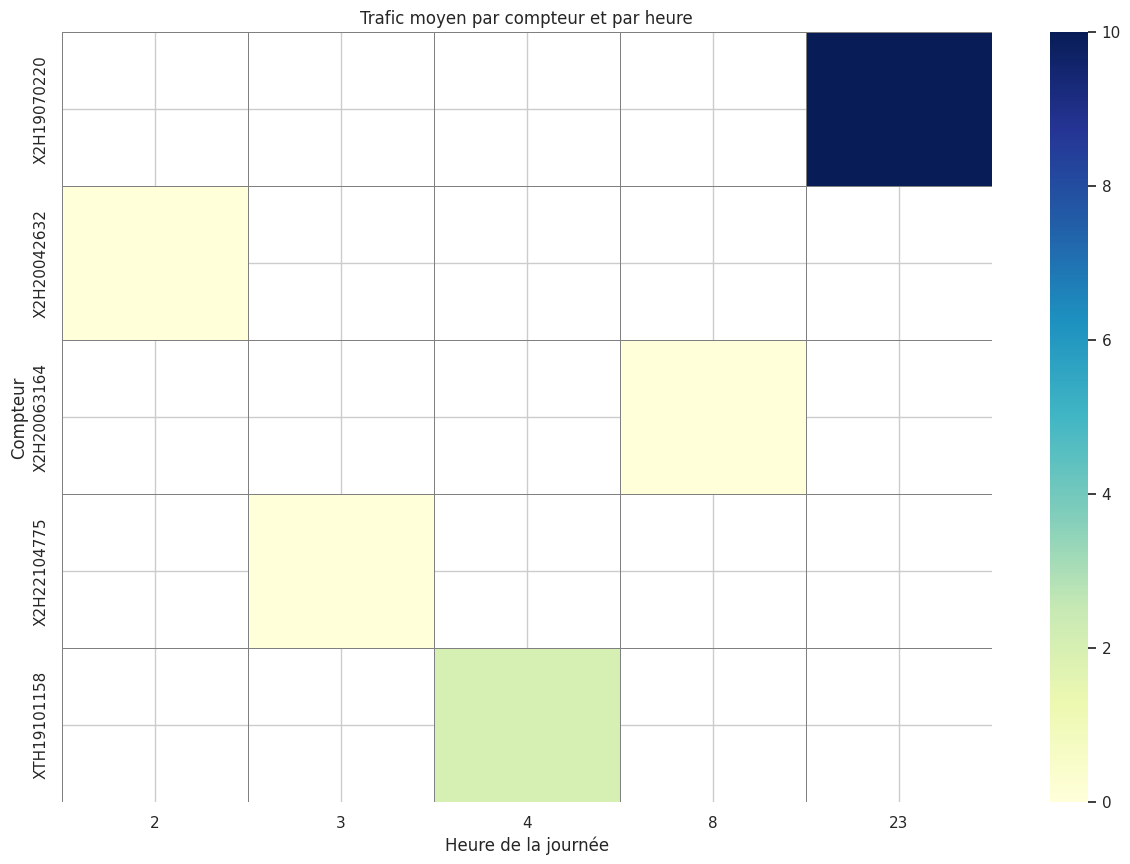

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Moyenne de passages par compteur et par heure
heatmap_data = df_counts.pivot_table(
    index='compteur',
    columns='hour',
    values='count',
    aggfunc='mean'
)

plt.figure(figsize=(15,10))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5, linecolor='gray')
plt.title("Trafic moyen par compteur et par heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Compteur")
plt.show()


In [73]:
import pandas as pd
import ast

# Charger le CSV
df = pd.read_csv("data/comptages_reel.csv")

# Extraire la date depuis 'intensity'
def extract_date(intensity_str):
    try:
        intensity_dict = ast.literal_eval(intensity_str)  # convertir le string en dict
        return intensity_dict['metadata']['TimeInstant']['value']
    except:
        return pd.NaT

df['date'] = df['intensity'].apply(extract_date)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Vérifier
df[['compteur', 'count', 'date']].head()


,compteur,count,date
0,XTH19101158,2,2025-11-27 04:00:00+00:00
1,X2H22104775,0,2025-11-27 03:00:00+00:00
2,X2H20042632,0,2024-02-01 02:00:00+00:00
3,X2H20063164,0,1899-11-30 08:00:00+00:00
4,X2H19070220,10,2025-11-26 23:00:00+00:00


Nombre total d'enregistrements : 5
Nombre de compteurs uniques : 5
Top 5 compteurs les plus fréquentés :
compteur
X2H19070220    10
XTH19101158     2
X2H20042632     0
X2H20063164     0
X2H22104775     0
Name: count, dtype: int64
Top 5 compteurs les moins fréquentés :
compteur
X2H20042632     0
X2H20063164     0
X2H22104775     0
XTH19101158     2
X2H19070220    10
Name: count, dtype: int64


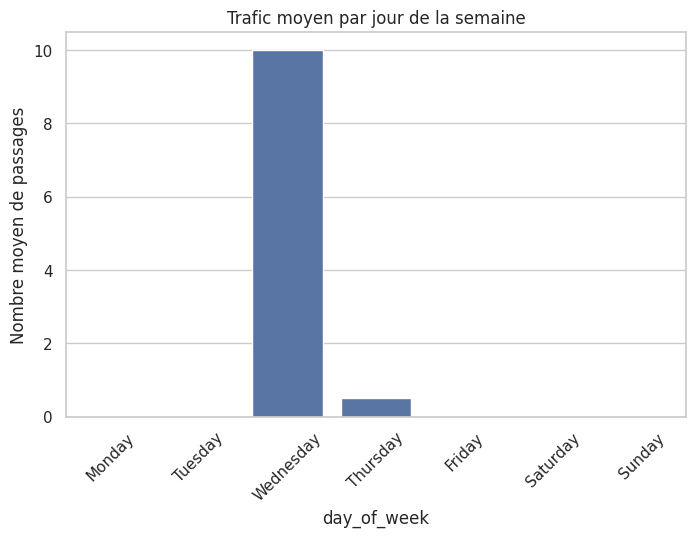

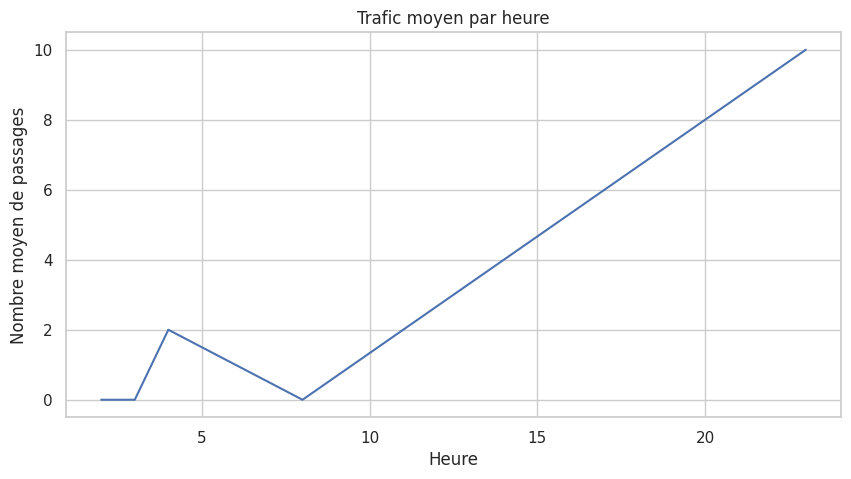

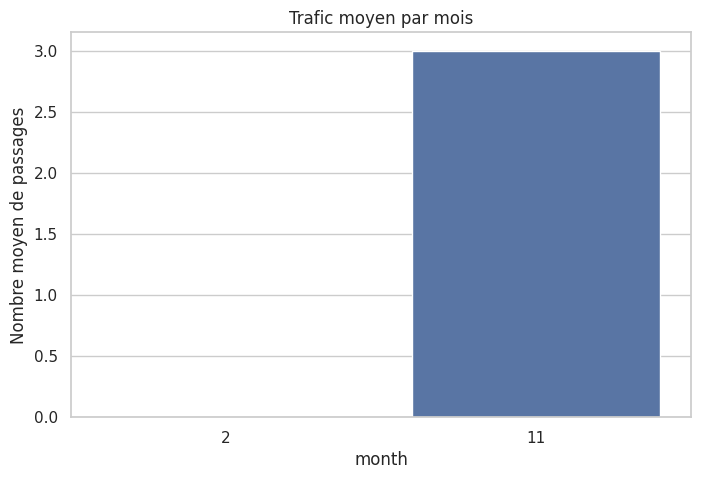

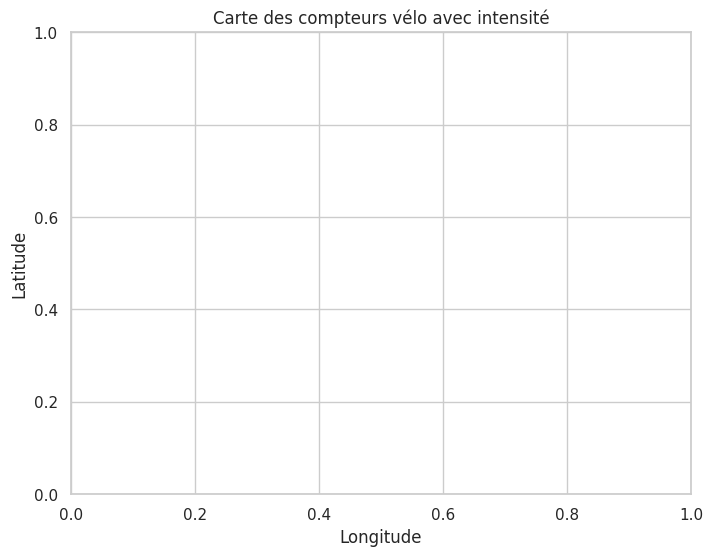

Compteurs avec anomalies détectées : ['X2H22104775' 'X2H20042632' 'X2H20063164' 'X2H19070220']


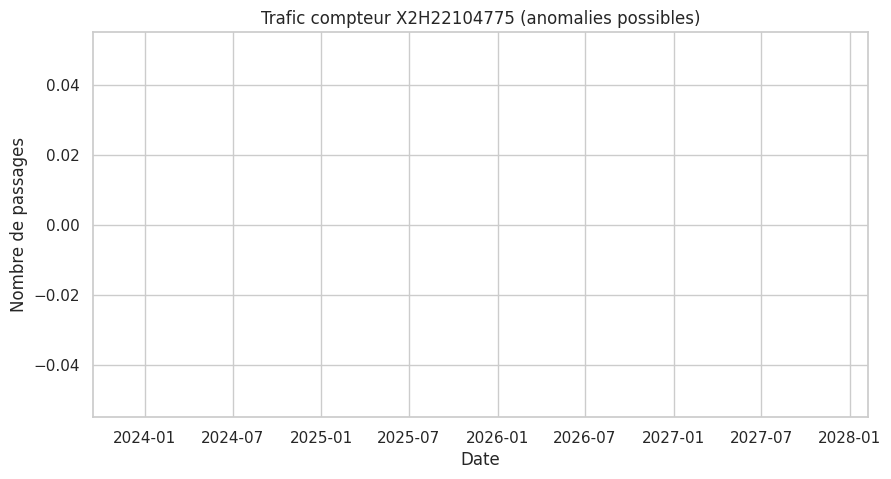

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast


df = pd.read_csv("/home/marwa/prevision-du-Trafic-Cyclable/notebooks/data/comptages_reel.csv")

# Extraire la date depuis la colonne 'intensity' (format JSON string)
def extract_date(intensity_str):
    try:
        intensity_dict = ast.literal_eval(intensity_str)  # convertir le string en dict
        return intensity_dict['metadata']['TimeInstant']['value']
    except:
        return pd.NaT

df['date'] = df['intensity'].apply(extract_date)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extraire jour de la semaine, heure et mois
df['day_of_week'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour
df['month'] = df['date'].dt.month


# 1️ Statistiques générales

print("Nombre total d'enregistrements :", len(df))
print("Nombre de compteurs uniques :", df['compteur'].nunique())
print("Top 5 compteurs les plus fréquentés :")
print(df.groupby('compteur')['count'].sum().sort_values(ascending=False).head())
print("Top 5 compteurs les moins fréquentés :")
print(df.groupby('compteur')['count'].sum().sort_values().head())


# 2️ Analyse temporelle


# a) Trafic moyen par jour de semaine
plt.figure(figsize=(8,5))
sns.barplot(
    x='day_of_week', 
    y='count', 
    data=df.groupby('day_of_week')['count'].mean().reset_index(),
    order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
plt.title("Trafic moyen par jour de la semaine")
plt.ylabel("Nombre moyen de passages")
plt.xticks(rotation=45)
plt.show()

# b) Trafic moyen par heure
plt.figure(figsize=(10,5))
sns.lineplot(
    x='hour', 
    y='count', 
    data=df.groupby('hour')['count'].mean().reset_index()
)
plt.title("Trafic moyen par heure")
plt.ylabel("Nombre moyen de passages")
plt.xlabel("Heure")
plt.show()

# c) Trafic moyen par mois 
plt.figure(figsize=(8,5))
sns.barplot(
    x='month', 
    y='count', 
    data=df.groupby('month')['count'].mean().reset_index()
)
plt.title("Trafic moyen par mois")
plt.ylabel("Nombre moyen de passages")
plt.show()

# 3️ Analyse spatiale (carte simple)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='lon', 
    y='lat', 
    size='count', 
    hue='count', 
    data=df, 
    palette='viridis', 
    legend=False
)
plt.title("Carte des compteurs vélo avec intensité")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# 4️ Détection d'anomalies

# Compteurs avec zéro passage ou valeurs très élevées
threshold_high = df['count'].quantile(0.99)
threshold_low = 0

anomalies = df[(df['count'] > threshold_high) | (df['count'] <= threshold_low)]
print("Compteurs avec anomalies détectées :", anomalies['compteur'].unique())

# Visualiser un compteur avec anomalies
if len(anomalies) > 0:
    sample_compteur = anomalies['compteur'].iloc[0]
    plt.figure(figsize=(10,5))
    df_sample = df[df['compteur']==sample_compteur]
    sns.lineplot(x='date', y='count', data=df_sample)
    plt.title(f"Trafic compteur {sample_compteur} (anomalies possibles)")
    plt.xlabel("Date")
    plt.ylabel("Nombre de passages")
    plt.show()


In [78]:
import requests
import pandas as pd

url = "https://portail-api-data.montpellier3m.fr/ecocounter?limit=1000"
response = requests.get(url)
compteurs = response.json()  # JSON des compteurs
df_compteurs = pd.DataFrame(compteurs)


In [84]:
from time import sleep
import requests
import pandas as pd

base_url = "https://portail-api-data.montpellier3m.fr/ecocounter_timeseries/"
records_list = []

for compteur_id in df_compteurs['id']:
    url_timeseries = f"{base_url}{compteur_id}/attrs/intensity"
    params = {
        "fromDate": "2023-01-01T00:00:00",
        "toDate": "2023-01-02T00:00:00"
    }
    
    response = requests.get(url_timeseries, params=params)
    if response.status_code == 200:
        data = response.json()
        
        # Vérifier la structure
        if isinstance(data, list):
            for rec in data:
                # Ici rec est un dictionnaire
                records_list.append({
                    "compteur": compteur_id,
                    "date": rec.get('observedAt'),
                    "count": rec.get('value')
                })
        else:
            print(f"Structure inattendue pour {compteur_id}: {data}")
    else:
        print(f"Erreur API pour le compteur {compteur_id} : {response.status_code}")
    
    sleep(0.2)

df_counts = pd.DataFrame(records_list)
df_counts['date'] = pd.to_datetime(df_counts['date'])


Structure inattendue pour urn:ngsi-ld:EcoCounter:XTH19101158: {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:XTH19101158', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.000+00:00']

KeyError: 'date'

In [81]:
if len(data['index']) != len(data['values']):
    print(f"Structure inattendue pour {data['entityId']}")


In [86]:
import pandas as pd

df = pd.DataFrame({'timestamp': data['index'], 'value': data['values']})
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').resample('h').asfreq().fillna(0)


In [87]:
from time import sleep
import requests
import pandas as pd

base_url = "https://portail-api-data.montpellier3m.fr/ecocounter_timeseries/"
records_list = []

for compteur_id in df_compteurs['id']:
    url_timeseries = f"{base_url}{compteur_id}/attrs/intensity"
    params = {
        "fromDate": "2023-01-01T00:00:00",
        "toDate": "2023-01-02T00:00:00"
    }
    
    response = requests.get(url_timeseries, params=params)
    if response.status_code == 200:
        data = response.json()
        
        # Vérifier la structure
        if isinstance(data, list):
            for rec in data:
                # Ici rec est un dictionnaire
                records_list.append({
                    "compteur": compteur_id,
                    "date": rec.get('observedAt'),
                    "count": rec.get('value')
                })
        else:
            print(f"Structure inattendue pour {compteur_id}: {data}")
    else:
        print(f"Erreur API pour le compteur {compteur_id} : {response.status_code}")
    
    sleep(0.2)

df_counts = pd.DataFrame(records_list)
df_counts['date'] = pd.to_datetime(df_counts['date'])


Structure inattendue pour urn:ngsi-ld:EcoCounter:XTH19101158: {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:XTH19101158', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.000+00:00']

KeyError: 'date'

In [ ]:
import pandas as pd
import requests
from tqdm import tqdm

# 1️⃣ Récupérer la liste des compteurs
url_ids = "https://portail-api-data.montpellier3m.fr/ecocounter?limit=1000"
ids = requests.get(url_ids).json()

compteur_ids = [c["id"] for c in ids]
print(f"{len(compteur_ids)} compteurs trouvés.")

# Dates
from_date = "2023-01-01T00:00:00"
to_date = "2023-01-02T00:00:00"

records = []

# 2️⃣ Boucle sur les compteurs
for compteur_id in tqdm(compteur_ids):
    url_timeseries = (
        f"https://portail-api-data.montpellier3m.fr/ecocounter_timeseries/"
        f"{compteur_id}/attrs/intensity"
        f"?fromDate={from_date}&toDate={to_date}"
    )

    response = requests.get(url_timeseries)

    if response.status_code != 200:
        print(f"⚠️ Erreur {response.status_code} pour compteur {compteur_id}")
        continue

    data = response.json()

    # Vérification du type
    if not isinstance(data, list):
        print(f"⚠️ Format inattendu pour compteur {compteur_id} : {data}")
        continue

    for rec in data:
        # Ignorer valeurs invalides
        if not isinstance(rec, dict):
            continue

        if "observedAt" not in rec or "value" not in rec:
            continue

        records.append({
            "compteur": compteur_id,
            "timestamp": rec["observedAt"],
            "count": rec["value"]
        })

# 3️ DataFrame final
df = pd.DataFrame(records)
df["timestamp"] = pd.to_datetime(df["timestamp"])

print(df.head())
df.shape


73 compteurs trouvés.


  1%|▏         | 1/73 [00:00<00:15,  4.70it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:XTH19101158 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:XTH19101158', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

  3%|▎         | 2/73 [00:00<00:16,  4.31it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22104775 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22104775', 'entityType': 'EcoCounter', 'index': ['2023-01-01T01:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00'], 'values': [1.0, 1.0, 1.0, 1.0, 8.0, 12.0, 12.0, 5.0, 3.0, 2.0]}


  4%|▍         | 3/73 [00:00<00:16,  4.32it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H20042632 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H20042632', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

  5%|▌         | 4/73 [00:00<00:16,  4.26it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H20063164 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H20063164', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

  7%|▋         | 5/73 [00:01<00:15,  4.25it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H19070220 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H19070220', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

  8%|▊         | 6/73 [00:01<00:15,  4.21it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:X2H22104771


 10%|▉         | 7/73 [00:01<00:15,  4.36it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:X2H21070350


 11%|█         | 8/73 [00:01<00:15,  4.33it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H21070349 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H21070349', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 12%|█▏        | 9/73 [00:02<00:14,  4.47it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H21070348 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H21070348', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 14%|█▎        | 10/73 [00:02<00:14,  4.37it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22104766 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22104766', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00'], 'values': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 6.0, 8.0, 15.0, 13.0, 7.0, 4.0]}


 15%|█▌        | 11/73 [00:02<00:14,  4.27it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H21070343 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H21070343', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 16%|█▋        | 12/73 [00:02<00:14,  4.17it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H20042635 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H20042635', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 18%|█▊        | 13/73 [00:03<00:14,  4.14it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22043030 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22043030', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 19%|█▉        | 14/73 [00:03<00:14,  4.13it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22043035 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22043035', 'entityType': 'EcoCounter', 'index': ['2023-01-01T01:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-02T00:00:00.000+00:00'], 'values': [0.0, 2.0, 2.0, 3.0, 5.0, 12.0, 1.0]}


 21%|██        | 15/73 [00:03<00:14,  4.00it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22043033 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22043033', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 22%|██▏       | 16/73 [00:03<00:14,  4.02it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:XTH21070328 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:XTH21070328', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 23%|██▎       | 17/73 [00:04<00:15,  3.57it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:X2H22104772


 25%|██▍       | 18/73 [00:04<00:14,  3.73it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:X2H22104777


 26%|██▌       | 19/73 [00:04<00:15,  3.55it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H21070342 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H21070342', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 27%|██▋       | 20/73 [00:05<00:17,  3.03it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H21070346 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H21070346', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 29%|██▉       | 21/73 [00:05<00:16,  3.11it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H20063163 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H20063163', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 30%|███       | 22/73 [00:05<00:15,  3.32it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22043034 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22043034', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.000+00:00'], 'values': [2.0, 5.0, 3.0, 2.0, 2.0, 3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 7.0, 2.0, 6.0, 4.0, 10.0, 6.0, 3.0, 0.0]}


 32%|███▏      | 23/73 [00:05<00:14,  3.49it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H21111120 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H21111120', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 33%|███▎      | 24/73 [00:06<00:14,  3.29it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22104767 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22104767', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00'], 'values': [4.0, 0.0, 0.0, 3.0]}


 34%|███▍      | 25/73 [00:06<00:13,  3.43it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H20042634 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H20042634', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 36%|███▌      | 26/73 [00:06<00:12,  3.67it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22043029 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22043029', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 37%|███▋      | 27/73 [00:07<00:12,  3.78it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22104765 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22104765', 'entityType': 'EcoCounter', 'index': ['2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00'], 'values': [0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 1.0, 0.0, 0.0, 0.0, 0.0]}


 38%|███▊      | 28/73 [00:07<00:12,  3.71it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22104768 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22104768', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00'], 'values': [3.0, 2.0, 3.0, 2.0, 1.0, 8.0, 9.0, 6.0, 14.0, 8.0, 12.0]}


 40%|███▉      | 29/73 [00:07<00:11,  3.80it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22104773 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22104773', 'entityType': 'EcoCounter', 'index': ['2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00'], 'values': [3.0, 2.0, 2.0, 4.0, 3.0, 11.0, 7.0, 13.0, 5.0, 5.0, 2.0, 5.0, 3.0, 0.0]}


 41%|████      | 30/73 [00:07<00:11,  3.75it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H20042633 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H20042633', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 42%|████▏     | 31/73 [00:08<00:10,  3.90it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22104774 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22104774', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00'], 'values': [5.0, 1.0, 3.0, 2.0, 1.0, 5.0, 5.0, 10.0, 14.0, 2.0]}


 44%|████▍     | 32/73 [00:08<00:10,  3.84it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22104769 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22104769', 'entityType': 'EcoCounter', 'index': ['2023-01-01T03:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-02T00:00:00.000+00:00'], 'values': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


 45%|████▌     | 33/73 [00:08<00:10,  3.92it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:XTH21015106


 47%|████▋     | 34/73 [00:08<00:09,  3.91it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H21070347 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H21070347', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 48%|████▊     | 35/73 [00:09<00:09,  3.86it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H21070344 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H21070344', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 49%|████▉     | 36/73 [00:09<00:09,  3.85it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22104770 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22104770', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.000+00:00'], 'values': [1.0, 2.0, 1.0, 0.0, 1.0, 4.0, 2.0, 0.0, 0.0]}


 51%|█████     | 37/73 [00:09<00:09,  3.74it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22043032 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22043032', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 52%|█████▏    | 38/73 [00:10<00:10,  3.44it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:X2H21111121


 53%|█████▎    | 39/73 [00:10<00:09,  3.41it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H20063161 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H20063161', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 55%|█████▍    | 40/73 [00:10<00:09,  3.49it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H21070345 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H21070345', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 56%|█████▌    | 41/73 [00:10<00:08,  3.60it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H21070341 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H21070341', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 58%|█████▊    | 42/73 [00:11<00:08,  3.69it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22043031 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22043031', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 59%|█████▉    | 43/73 [00:11<00:08,  3.62it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H20063162 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H20063162', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 60%|██████    | 44/73 [00:11<00:08,  3.60it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H21070351 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H21070351', 'entityType': 'EcoCounter', 'index': ['2023-01-01T00:00:00.000+00:00', '2023-01-01T01:00:00.000+00:00', '2023-01-01T02:00:00.000+00:00', '2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T05:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T07:00:00.000+00:00', '2023-01-01T08:00:00.000+00:00', '2023-01-01T09:00:00.000+00:00', '2023-01-01T10:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T12:00:00.000+00:00', '2023-01-01T13:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T16:00:00.000+00:00', '2023-01-01T17:00:00.000+00:00', '2023-01-01T18:00:00.000+00:00', '2023-01-01T19:00:00.000+00:00', '2023-01-01T20:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00', '2023-01-02T00:00:00.00

 62%|██████▏   | 45/73 [00:11<00:07,  3.51it/s]

⚠️ Format inattendu pour compteur urn:ngsi-ld:EcoCounter:X2H22104776 : {'attrName': 'intensity', 'entityId': 'urn:ngsi-ld:EcoCounter:X2H22104776', 'entityType': 'EcoCounter', 'index': ['2023-01-01T03:00:00.000+00:00', '2023-01-01T04:00:00.000+00:00', '2023-01-01T06:00:00.000+00:00', '2023-01-01T11:00:00.000+00:00', '2023-01-01T14:00:00.000+00:00', '2023-01-01T15:00:00.000+00:00', '2023-01-01T21:00:00.000+00:00', '2023-01-01T22:00:00.000+00:00', '2023-01-01T23:00:00.000+00:00'], 'values': [4.0, 1.0, 1.0, 4.0, 4.0, 8.0, 10.0, 9.0, 2.0]}


 63%|██████▎   | 46/73 [00:12<00:07,  3.55it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:X2H20104132


 64%|██████▍   | 47/73 [00:12<00:07,  3.60it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:XAH23111501


 66%|██████▌   | 48/73 [00:12<00:07,  3.18it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:867228050089043


 67%|██████▋   | 49/73 [00:13<00:07,  3.28it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:867228050089217


 68%|██████▊   | 50/73 [00:13<00:06,  3.41it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:867228050089787


 70%|██████▉   | 51/73 [00:13<00:06,  3.47it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:867228050089159


 71%|███████   | 52/73 [00:14<00:06,  3.36it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:867228050092989


 73%|███████▎  | 53/73 [00:14<00:05,  3.49it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:ED223110501


 74%|███████▍  | 54/73 [00:14<00:05,  3.73it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:ED223110497


 75%|███████▌  | 55/73 [00:14<00:05,  3.52it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:ED223110495


 77%|███████▋  | 56/73 [00:15<00:04,  3.46it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:ED223110500


 78%|███████▊  | 57/73 [00:15<00:04,  3.52it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:ED223110496


 79%|███████▉  | 58/73 [00:15<00:04,  3.48it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:XTH24072390


 81%|████████  | 59/73 [00:15<00:03,  3.70it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:X2H24042101


 82%|████████▏ | 60/73 [00:16<00:03,  3.88it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:ED223110494


 84%|████████▎ | 61/73 [00:16<00:03,  3.80it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:D223110499


 85%|████████▍ | 62/73 [00:16<00:02,  3.91it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:ED223110499


 86%|████████▋ | 63/73 [00:16<00:02,  3.79it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:X2H25023006


 88%|████████▊ | 64/73 [00:17<00:02,  3.71it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:ZLT25011699


 89%|████████▉ | 65/73 [00:17<00:02,  3.63it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:COM23120112


 90%|█████████ | 66/73 [00:17<00:01,  3.61it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:COM23120113


 92%|█████████▏| 67/73 [00:18<00:01,  3.66it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:COM23120117


 93%|█████████▎| 68/73 [00:18<00:01,  3.55it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:COM23120114


 95%|█████████▍| 69/73 [00:18<00:01,  3.69it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:COM23120111


 96%|█████████▌| 70/73 [00:18<00:00,  3.66it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:COM23120110


 97%|█████████▋| 71/73 [00:19<00:00,  3.55it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:COM24010120


 99%|█████████▊| 72/73 [00:19<00:00,  3.48it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:COM24010121


100%|██████████| 73/73 [00:19<00:00,  3.69it/s]

⚠️ Erreur 404 pour compteur urn:ngsi-ld:EcoCounter:COM24010119


KeyError: 'timestamp'

In [7]:
import pandas as pd
import requests
from tqdm import tqdm
import urllib.parse

# ---------------------------------------------
# 🔍 1) TESTS DIRECTS (ce que tu veux afficher)
# ---------------------------------------------

response = requests.get("https://portail-api-data.montpellier3m.fr/ecocounter?limit=1000")
print("📌 Test 1 : Liste des compteurs :")
print(response.json())

res = requests.get(
    "https://portail-api-data.montpellier3m.fr/ecocounter_timeseries/"
    "urn%3Angsi-ld%3AEcoCounter%3ACOM23120110/attrs/intensity"
    "?fromDate=2025-11-22T00%3A00%3A00&toDate=2025-11-24T00%3A00%3A00"
)
print("\n📌 Test 2 : Timeseries pour un compteur :")
print(res.json())

# ---------------------------------------------
# ▶️ 2) PIPELINE OFFICIEL (avec les vraies données)
# ---------------------------------------------

ids = response.json()
compteur_ids = [c["id"] for c in ids]
print(f"\n🔢 {len(compteur_ids)} compteurs trouvés.")

# Dates analysées
from_date = "2023-01-01T00:00:00"
to_date = "2023-01-02T00:00:00"

records = []

# ---------------------------------------------
# 🔁 3) Boucle sur tous les compteurs
# ---------------------------------------------
for compteur_id in tqdm(compteur_ids):

    full_id = f"urn:ngsi-ld:EcoCounter:{compteur_id}"
    encoded_id = urllib.parse.quote(full_id)

    url_timeseries = (
        f"https://portail-api-data.montpellier3m.fr/ecocounter_timeseries/"
        f"{encoded_id}/attrs/intensity"
        f"?fromDate={from_date}&toDate={to_date}"
    )

    response_ts = requests.get(url_timeseries)

    if response_ts.status_code != 200:
        print(f"⚠️ Erreur {response_ts.status_code} pour {compteur_id}")
        continue

    data = response_ts.json()

    if "index" not in data or "values" not in data:
        print(f"⚠️ Format inattendu pour {compteur_id}: {data}")
        continue

    for timestamp, value in zip(data["index"], data["values"]):
        records.append({
            "compteur": compteur_id,
            "timestamp": timestamp,
            "count": value
        })

# ---------------------------------------------
# 📊 4) DataFrame final
# ---------------------------------------------
df = pd.DataFrame(records)
df["timestamp"] = pd.to_datetime(df["timestamp"])

print("\n📌 Aperçu du DataFrame :")
print(df.head())
print("Dimensions :", df.shape)


OSError: Could not find a suitable TLS CA certificate bundle, invalid path: /home/marwa/prevision-du-Trafic-Cyclable/.venv/lib/python3.12/site-packages/certifi/cacert.pem